In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
seaborn.set_style('dark')
np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
import sklearn
import sklearn.metrics
import sklearn.grid_search
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.preprocessing
import sklearn.pipeline
import pescador

In [3]:
import glob

In [4]:
def load_file(filename, n_pos=32, n_neg=32):
    
    data = np.load(filename)
    
    d = data['X'].shape[1]
    
    if n_pos is None:
        return data['X'], data['Y']
    
    
    positives = np.flatnonzero(data['Y'])
    negatives = np.flatnonzero(1-data['Y'])
    n_pos = min(n_pos, len(positives))
    n_neg = min(n_neg, len(negatives))
    
    X = np.empty((n_pos + n_neg, d), dtype=np.float32)
    Y = np.zeros((n_pos + n_neg), dtype=np.int32)
    
    if n_pos > 0:
        idx_pos = np.random.choice(positives, size=n_pos, replace=False)
    
        X[:n_pos] = np.take(data['X'], idx_pos, axis=0)
        Y[:n_pos] = 1
    
    if n_neg > 0:
        idx_neg = np.random.choice(negatives, size=n_neg, replace=False)
        X[n_pos:] = np.take(data['X'], idx_neg, axis=0)
    
    return X, Y

In [5]:
def load_batch(files, n_pos=32, n_neg=32):
    
    X = []
    Y = []
    
    for fn in files:
        _x, _y = load_file(fn, n_pos=n_pos, n_neg=n_neg)
        if _x.shape[0] == 0:
            continue
        X.append(_x)
        Y.append(_y)
        
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    return X, Y

In [6]:
files = sorted(glob.glob('../data/labeled_features/SALAMI_*_beats.npz'))
#files = sorted(glob.glob('../data/labeled_features/Isophonics_*_beats.npz'))

In [7]:
filesplitter = sklearn.cross_validation.ShuffleSplit(len(files), n_iter=1, test_size=0.10, random_state=5)
_files = np.asarray(files)

In [8]:
import sklearn.ensemble

In [9]:
for trainf, testf in filesplitter:
    
    print 'Loading training data...'
    X_train, Y_train = load_batch([_files[_] for _ in trainf],
                                 n_pos=10,
                                 n_neg=100)
    
    _model = sklearn.grid_search.GridSearchCV(sklearn.linear_model.SGDClassifier(loss='log', verbose=1),
                                             {'alpha': np.logspace(-3, 3, num=6, endpoint=False),
                                             'penalty': ['l1', 'l2', 'elasticnet']},
                                             n_jobs=3, verbose=1)
    
    #_model = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(),
    #                                         {'max_depth': np.arange(2, 11)},
    #                                         n_jobs=3, verbose=1)
    
    feature = sklearn.preprocessing.StandardScaler()
    model = sklearn.pipeline.Pipeline([('scaler', feature), ('predictor', _model)])
    
    model.fit(X_train, Y_train)
    
    print 'Loading testing data...'
    X_test, Y_test = load_batch([_files[_] for _ in testf],
                                n_pos=None,
                                n_neg=None)

Loading training data...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:    9.4s
[Parallel(n_jobs=3)]: Done  50 out of  54 | elapsed:  1.6min remaining:    7.8s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:  1.7min finished


-- Epoch 1
Norm: 1.42, NNZs: 246, Bias: -6.881097, T: 66097, Avg. loss: 0.358848-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 507.75, NNZs: 684, Bias: -551.229112, T: 44064, Avg. loss: 29.973271Norm: 476.28, NNZs: 697, Bias: -520.299053, T: 44066, Avg. loss: 27.528277Norm: 465.77, NNZs: 655, Bias: -485.325600, T: 44064, Avg. loss: 26.547831


Total training time: 0.79 seconds.
Total training time: 0.93 seconds.
Total training time: 1.07 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 497.62, NNZs: 656, Bias: -535.634241, T: 88128, Avg. loss: 24.991801Norm: 468.04, NNZs: 655, Bias: -503.737746, T: 88132, Avg. loss: 22.934476Norm: 457.30, NNZs: 620, Bias: -468.325074, T: 88128, Avg. loss: 22.168596


Total training time: 1.43 seconds.
Total training time: 1.76 seconds.
Total training time: 1.97 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 492.94, NNZs: 642, Bias: -525.911678, T: 132192, Avg. loss: 22.914418Norm: 464.11, NNZs: 628, Bias: -493.627249, T: 132198, Avg. loss: 21.017595Norm: 453.5

In [10]:
M = model.steps[1][1]

In [11]:
M.best_params_

{'alpha': 0.10000000000000001, 'penalty': 'elasticnet'}

<matplotlib.colorbar.Colorbar instance at 0x7fe1e32c27a0>

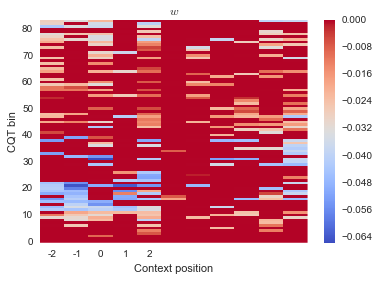

In [12]:
w = model.steps[1][1].best_estimator_.coef_[0]
w = w.reshape((-1, 84))
plt.imshow(w.T, aspect='auto', interpolation='none', cmap='coolwarm', origin='lower')
plt.ylabel('CQT bin')
plt.xlabel('Context position')
plt.title('$w$')
plt.xticks(np.arange(5), np.arange(-2, 3))
plt.colorbar()

In [13]:
print sklearn.metrics.classification_report(Y_train, model.predict(X_train))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     60467
          1       0.67      0.01      0.01      5630

avg / total       0.89      0.92      0.88     66097



In [ ]:
sklearn.metrics.accuracy_score(Y_train, model.predict(X_train))

0.91510961163139026

In [ ]:
Y_pred = [model.predict(xt) for xt in X_test]

In [ ]:
Y_pred_proba = np.concatenate([model.predict_proba(xt) for xt in X_test], axis=0)

In [ ]:
Y_pred = np.concatenate(Y_pred, axis=0)

In [ ]:
print sklearn.metrics.classification_report(Y_test, Y_pred)

In [ ]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

---

In [32]:
import cPickle as pickle

In [33]:
pickle.dump({'model': model, 'dataset': 'salami_beat'},
            open('../data/similarity_model_salami_beat.pickle', 'w'))
#pickle.dump({'model': model, 'dataset': 'isophonics_beat'},
#            open('../data/similarity_model_isophonics_beat.pickle', 'w'))

---

In [98]:
Xtrains2 = np.mean(X_train**2, axis=1, keepdims=True)

In [99]:
Xtests2 = np.mean(X_test**2, axis=1, keepdims=True)

In [100]:
seaborn.set_style('darkgrid')

In [101]:
import sklearn.neighbors

In [102]:
KDE_pos = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KernelDensity(),
                                           {'bandwidth': np.linspace(0.1, 1.0, 5)},
                                           verbose=1,
                                           n_jobs=3,
                                           cv=5)
KDE_pos.fit(Xtrains2[Y_train > 0])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:   11.5s
[Parallel(n_jobs=3)]: Done  21 out of  25 | elapsed:  1.5min remaining:   17.3s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=3,
       param_grid={'bandwidth': array([ 0.1  ,  0.325,  0.55 ,  0.775,  1.   ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [103]:
KDE_neg = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KernelDensity(),
                                           {'bandwidth': np.linspace(0.1, 1.0, 3)},
                                           verbose=1,
                                           n_jobs=3,
                                           cv=5)
KDE_neg.fit(Xtrains2[Y_train < 1])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:   14.5s
[Parallel(n_jobs=3)]: Done  11 out of  15 | elapsed:  1.2min remaining:   25.4s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=3,
       param_grid={'bandwidth': array([ 0.1 ,  0.55,  1.  ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [104]:
Y_pred_kde = (KDE_pos.best_estimator_.score_samples(Xtests2) >
              KDE_neg.best_estimator_.score_samples(Xtests2))

In [105]:
print sklearn.metrics.classification_report(Y_test[:len(Y_pred_kde)], Y_pred_kde)

             precision    recall  f1-score   support

          0       0.66      0.68      0.67    143276
          1       0.58      0.56      0.57    114243

avg / total       0.62      0.62      0.62    257519



ValueError: need more than 1 value to unpack

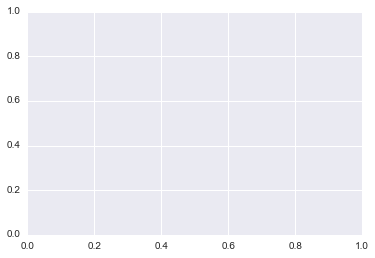

In [106]:
seaborn.kdeplot(np.log(Xtrains2[Y_train > 0]), shade=True, label='Positive')
seaborn.kdeplot(np.log(Xtrains2[Y_train < 1]), shade=True, label='Negative')
plt.legend(loc='best')